## Instalando e Carregando os Pacotes

In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [ ]:
!pip install -q torch==1.13.1

In [ ]:
!pip install -q torch_geometric

Para instalar o torch_sparse é preciso ter compilador C++ na sua máquina.

- Usuários Windows devem instalar o Microsoft Visual C++ Redistributable.
- Usuários MacOS devem instalar o xcode.
- Usuários Linux podem instalar o gcc.

In [ ]:
!pip install -q torch_sparse

In [ ]:
!pip install -q torch_scatter

In [ ]:
!pip install -q networkx

In [ ]:
!pip install -q pyvis

In [ ]:
!pip install -q xgboost

In [ ]:
!pip install -q tensorboard

In [ ]:
# Imports
import xgboost
import torch
import sklearn
import pyvis
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.semi_supervised import LabelPropagation
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from pyvis.network import Network
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

seaborn   : 0.11.2
torch     : 1.13.1
pyvis     : 0.3.1
matplotlib: 3.5.2
scipy     : 1.10.0
numpy     : 1.21.5
pandas    : 1.4.4
networkx  : 3.0
sklearn   : 1.1.1
xgboost   : 1.7.3



## Carregando os Dados

O arquivo **dataset1.csv** é o mais importante, pois contém um conjunto de IPs maliciosos que foram relatados pelos agentes do software de monitoramento para um determinado tipo de ataque (leia o manual em pdf com a descrição do projeto).

O arquivo **dataset2.csv** contém informações gerais sobre os agentes do software de monitoramento dos IPs maliciosos no primeiro conjunto de dados. Cada linha é um agente.

O arquivo **dataset3.csv** contém as descrições do provedor ao qual o IP malicioso pertence.

In [ ]:
# Carrega o dataset1
dados1 = pd.read_csv("dados/dataset1.csv")

In [ ]:
dados1.shape

(29160, 5)

In [ ]:
dados1.sample(5)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor
16350,1332232,{92263},Crawler,NaN,3320.0
10047,1133458,{77642},Scanner,NaN,197688.0
21710,1341421,{92263},Crawler,NaN,15451.0
20956,1340371,{92263},Crawler,NaN,34769.0
17158,1334615,{92263},Crawler,NaN,3320.0


In [ ]:
# Carrega o dataset2
dados2 = pd.read_csv("dados/dataset2.csv")

In [ ]:
dados2.shape

(2121, 5)

In [ ]:
dados2.sample(5)

,id_agente,idade_dias,atividade_dias,honey_pot,num_ips_reportados
328,74210,47,47,0.08,236
1084,68798,61,61,0.18,1427
41,92097,25,22,0.12,48
1399,39233,122,121,0.28,281
582,561,336,327,0.02,20083


In [ ]:
# Carrega o dataset3
dados3 = pd.read_csv("dados/dataset3.csv")

In [ ]:
dados3.shape

(15161, 3)

In [ ]:
dados3.sample(5)

,id_provedor,num_ips_reportados,nome_provedor
8830,264382,2,Rctel Solucoes em Telecom
11270,49184,1,MediaService Ltd.
11537,52724,1,Adriano Telecomunicacoes Ltda Me
6989,12753,2,Teva Pharmaceutical Industries Limited
11517,52617,1,WF COMERCIO DE SUPRIMENTOS DE INFORMATICA LTDA


## Limpeza e Organização dos Dados

Vamos verificar os valores ausentes em cada dataset.

In [ ]:
dados1.isna().sum()

id_registro_ip        0
id_agente             0
tipo_ataque           0
ip_validado       25964
id_provedor           1
dtype: int64

In [ ]:
dados2.isna().sum()

id_agente             0
idade_dias            0
atividade_dias        0
honey_pot             0
num_ips_reportados    0
dtype: int64

In [ ]:
dados3.isna().sum()

id_provedor           0
num_ips_reportados    0
nome_provedor         1
dtype: int64

Vamos verificar os ids únicos em dados1.

In [ ]:
# Vamos verificar se os ids são únicos
dados1.id_registro_ip.is_unique

True

Vejamos se é possível concatenar dados1 e dados3.

In [ ]:
# Vamos checar os provedores comuns entre dados1 e dados3
len(dados1[dados1['id_provedor'].isin(dados3['id_provedor'].value_counts()[dados3['id_provedor'].value_counts()==1].index)])

29146

In [ ]:
# Vamos unir dados1 e dados3 pela coluna comum entre eles
df = dados1.join(dados3.set_index('id_provedor'), on = 'id_provedor')

In [ ]:
df.sample(5)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor
12399,1256741,{88632},Other,True,14061.0,19829.0,DIGITALOCEAN-ASN
19370,1338331,{19463},Bruteforce,NaN,7922.0,1714.0,COMCAST-7922
7533,943886,{99356},Scanner,False,13335.0,895.0,CLOUDFLARENET
7617,951763,"{22115, 75959}",Bruteforce,NaN,45090.0,5947.0,Shenzhen Tencent Computer Systems Company Limited
11381,1200742,{7286},Scanner,NaN,8151.0,1241.0,Uninet S.A. de C.V.


In [ ]:
df.isna().sum()

id_registro_ip            0
id_agente                 0
tipo_ataque               0
ip_validado           25964
id_provedor               1
num_ips_reportados       14
nome_provedor            14
dtype: int64

In [ ]:
# Dropna
df = df.dropna(subset = ["nome_provedor"])

In [ ]:
# Dropna
df = df.dropna(subset = ["num_ips_reportados"])

In [ ]:
# Dropna
df = df.dropna(subset = ["id_provedor"])

In [ ]:
df.isna().sum()

id_registro_ip            0
id_agente                 0
tipo_ataque               0
ip_validado           25959
id_provedor               0
num_ips_reportados        0
nome_provedor             0
dtype: int64

In [ ]:
df.shape

(29146, 7)

## Engenharia de Atributos

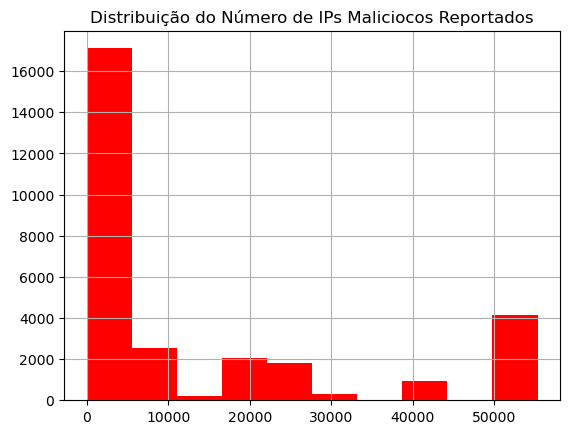

In [ ]:
# Verifica a distribuição do número de IPs reportados
df.num_ips_reportados.hist(color = 'red')
plt.title('Distribuição do Número de IPs Maliciocos Reportados', fontsize = 12)
plt.show()

Análise:

* Podemos notar que os dados são **altamente distorcidos positivamente (desviados à direita)**.

* **Alta porcentagem de valores discrepantes**.

Solução:

* **Categorização em 3 categorias ordenadas**, desde que possamos ver 3 intervalos separados.

* Associar os dados agrupados com **Transformação Box-Cox** *(transformação não linear).* para controlar a heterocedasticidade para que a variação não dependa mais da magnitude e para que possamos equalizar a variação em todos os intervalos do número de ips detectados (especialmente porque optamos por categorizar os dados).

### Transformação Box-Cox

A Transformação Box-Cox é uma técnica estatística que ajusta os dados para que sigam uma distribuição normal ou aproximadamente normal. Essa transformação envolve calcular uma função Box-Cox, que é uma família de transformações paramétricas. A Transformação Box-Cox é comumente usada para melhorar a precisão e confiabilidade de análises estatísticas, como regressão linear e ANOVA, que pressupõem a normalidade dos dados.

In [ ]:
# Transformação Box-Cox
fitted_data, _ = stats.boxcox(df['num_ips_reportados'])

In [ ]:
# Nova variável com as categorias
df['num_ips_reportados_bc'] = fitted_data

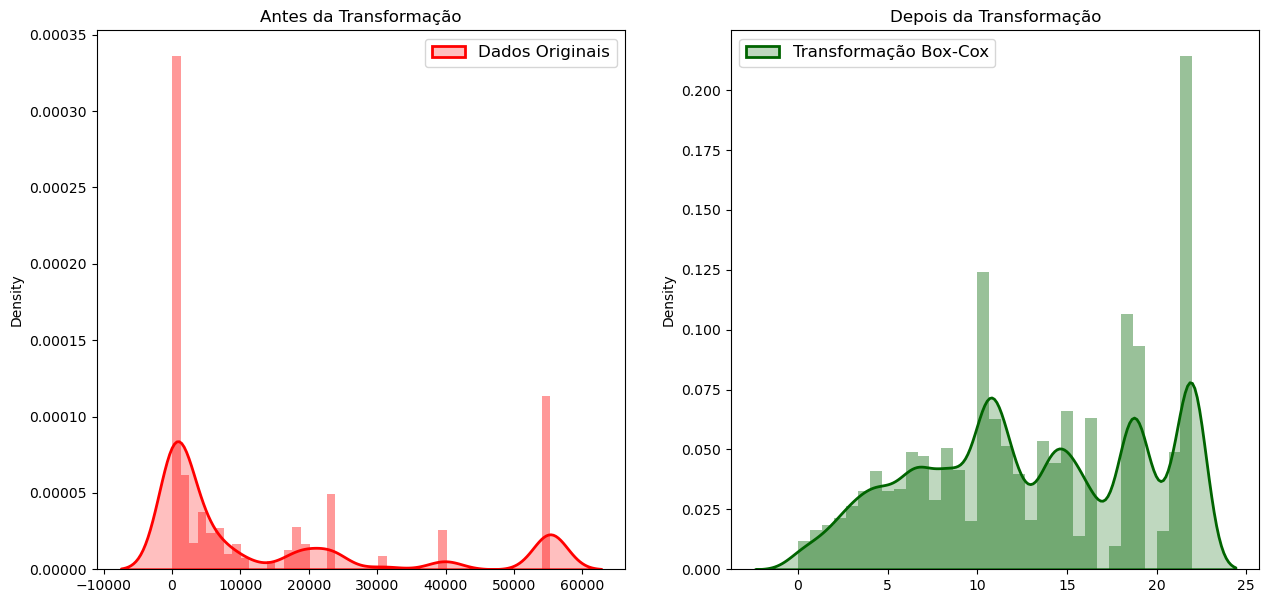

In [ ]:
# Plot

# Subplots
fig, ax = plt.subplots(1, 2)

# Subplot 1
sns.distplot(df.num_ips_reportados,
            hist = True,
            kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            color ="red",
            ax = ax[0])

# Subplot 2
sns.distplot(df.num_ips_reportados_bc,
            hist = True,
            kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            color ="darkgreen",
            ax = ax[1])

# Eixos
ax[0].set_title("Antes da Transformação", fontsize = 12)
ax[1].set_title("Depois da Transformação", fontsize = 12)

# Labels desligados
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)

# Legendas
ax[0].legend(labels = ["Dados Originais"], fontsize = 12)
ax[1].legend(labels = ["Transformação Box-Cox"], fontsize = 12)

# Formatação
fig.set_figheight(7)
fig.set_figwidth(15)

plt.show()

### Categorização

In [ ]:
# Cria variável
ips_reportados = df['num_ips_reportados_bc']

In [ ]:
# Valos min, max e os bins
min = int(np.min(ips_reportados))
max = int(np.max(ips_reportados))
bins = np.linspace(min, max, 4)

In [ ]:
# Aplica a binarização
df['ips_reportados_binned'] = pd.cut(ips_reportados, bins, right = False, precision = 5, labels = [0,1,2])

In [ ]:
df.ips_reportados_binned.dtype

CategoricalDtype(categories=[0, 1, 2], ordered=True)

In [ ]:
df.ips_reportados_binned.value_counts()

1    10060
2     8979
0     5945
Name: ips_reportados_binned, dtype: int64

In [ ]:
# Transforma o tipo em `int` para algoritmos de aprendizado de máquina que não suportam o tipo `cat`
df['ips_reportados_binned'] = pd.factorize(df['ips_reportados_binned'])[0]

In [ ]:
df.ips_reportados_binned.dtype

dtype('int64')

In [ ]:
df.head()

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned
0,3,{21},Exploit,NaN,16509.0,30914.0,AMAZON-02,19.997131,0
1,4,{25},Exploit,NaN,16509.0,30914.0,AMAZON-02,19.997131,0
2,9,"{20354, 3587, 83714, 34181, 33423, 52497, 786,...",Bruteforce,True,206728.0,14.0,Media Land LLC,3.088124,1
3,78,{20},Bruteforce,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2
4,92,{28},Exploit,NaN,16509.0,30914.0,AMAZON-02,19.997131,0


In [ ]:
# Substitui as chaves por colchetes para simplificar a contagem de agentes
df["id_agente"] = df["id_agente"].apply(lambda x :pd.eval(x.replace("{","[").replace("}","]")))

In [ ]:
df.head()

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned
0,3,[21],Exploit,NaN,16509.0,30914.0,AMAZON-02,19.997131,0
1,4,[25],Exploit,NaN,16509.0,30914.0,AMAZON-02,19.997131,0
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",Bruteforce,True,206728.0,14.0,Media Land LLC,3.088124,1
3,78,[20],Bruteforce,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2
4,92,[28],Exploit,NaN,16509.0,30914.0,AMAZON-02,19.997131,0


In [ ]:
# Contagem do número de agentes
df["num_id_agente"] = df["id_agente"].apply(len)

In [ ]:
df.head()

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente
0,3,[21],Exploit,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1
1,4,[25],Exploit,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",Bruteforce,True,206728.0,14.0,Media Land LLC,3.088124,1,43
3,78,[20],Bruteforce,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,1
4,92,[28],Exploit,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1


In [ ]:
# Cria o encoder
le = LabelEncoder()

In [ ]:
# Aplica o encoder na variável tipo_ataque
df['tipo_ataque'] = le.fit_transform(df['tipo_ataque'])

In [ ]:
df.head()

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente
0,3,[21],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1
1,4,[25],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,43
3,78,[20],0,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,1
4,92,[28],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1


## Análise Exploratória

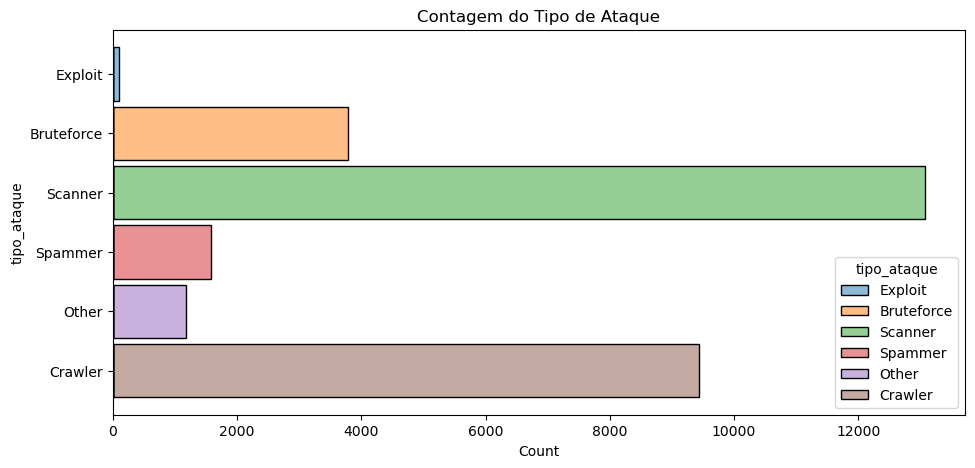

In [ ]:
# Distribuição do tipo de ataque
plt.figure(figsize = (11,5))
ax = sns.histplot(data = dados1,
                  y = "tipo_ataque",
                  binwidth = 5,
                  hue = 'tipo_ataque',
                  shrink = .9,
                  legend = True)
plt.title("Contagem do Tipo de Ataque")
plt.show()

In [ ]:
# Provedores com Maior Número de IPs Associados a Ataques
top10 = df.id_provedor.value_counts().nlargest(10).index
print("Provedores com Maior Número de IPs Associados a Ataques:\n")
for id in top10 :
    print(dados3[dados3["id_provedor"]==id].nome_provedor.item())

Provedores com Maior Número de IPs Associados a Ataques:

Deutsche Telekom AG
Vodafone GmbH
Kyivstar PJSC
Chinanet
CLOUDFLARENET
Hetzner Online GmbH
Alpha Strike Labs GmbH
DIGITALOCEAN-ASN
Telefonica Germany
MICROSOFT-CORP-MSN-AS-BLOCK


In [ ]:
# Provedores com Maior Número de IPs Associados a Ataques (Validados)
df_valid = df.dropna(subset = ['ip_validado'])
top10_v = df_valid.id_provedor.value_counts().nlargest(10).index
print("Provedores com Maior Número de IPs Associados a Ataques (Validados):\n")
for id in top10_v :
    print(dados3[dados3["id_provedor"]==id].nome_provedor.item())

Provedores com Maior Número de IPs Associados a Ataques (Validados):

CLOUDFLARENET
MICROSOFT-CORP-MSN-AS-BLOCK
PONYNET
Cia Triad Security LLC
DIGITALOCEAN-ASN
Alpha Strike Labs GmbH
QUINTEX
Chinanet
OVH SAS
Hetzner Online GmbH


In [ ]:
df_valid.head(3)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,43
3,78,[20],0,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,1
7,114,"[63782, 77576, 54740, 72791, 22111]",0,True,4134.0,39891.0,Chinanet,20.856758,0,5


In [ ]:
# Provedores com Mais IPs Reportados Pelos Agentes de Monitoramento
top10 = df.loc[df.num_id_agente.nlargest(10).index].id_provedor
print("Provedores com Mais IPs Reportados Pelos Agentes de Monitoramento:\n")
for i in top10 :
    print(dados3[dados3["id_provedor"]==i].nome_provedor.item())

Provedores com Mais IPs Reportados Pelos Agentes de Monitoramento:

CLOUDFLARENET
CLOUDFLARENET
China Mobile communications corporation
Chinanet
Chinanet
China Mobile communications corporation
China Mobile communications corporation
China Mobile communications corporation
Chinanet
Chinanet


In [ ]:
# Mesmo anterior mas para ips validados
top10_v = df_valid.loc[df_valid.num_id_agente.nlargest(10).index].id_provedor
print("Provedores com Mais IPs (Validados) Reportados Pelos Agentes de Monitoramento:\n")
for i in top10_v :
    print(dados3[dados3["id_provedor"]==i].nome_provedor.item())

Provedores com Mais IPs (Validados) Reportados Pelos Agentes de Monitoramento:

China Mobile communications corporation
Chinanet
Chinanet
China Mobile communications corporation
China Mobile communications corporation
China Mobile communications corporation
Chinanet
Chinanet
China Mobile communications corporation
China Mobile communications corporation


In [ ]:
df.head()

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente
0,3,[21],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1
1,4,[25],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,43
3,78,[20],0,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,1
4,92,[28],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1


In [ ]:
dados2.head()

,id_agente,idade_dias,atividade_dias,honey_pot,num_ips_reportados
0,42266,116,116,0.04,3636
1,11213,211,157,0.31,1555
2,87345,30,28,0.09,70
3,85892,32,31,0.71,136
4,9695,240,234,0.02,17932


In [ ]:
# Distribuição da média de atividade_dias dos agentes que relataram cada IP malicioso
# (somente para os IPs validados)
df["media_atividade_dias"] = df.id_agente.apply(lambda x: dados2.set_index("id_agente").loc[x].atividade_dias.mean())

In [ ]:
# Distribuição da média de idade_dias dos agentes que relataram cada IP malicioso
# (somente para os IPs validados)
df["media_idade_dias"] = df.id_agente.apply(lambda x: dados2.set_index("id_agente").loc[x].idade_dias.mean())

In [ ]:
df.head()

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias
0,3,[21],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1,397.000000,407.000000
1,4,[25],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1,401.000000,407.000000
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,43,141.883721,163.116279
3,78,[20],0,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,1,385.000000,407.000000
4,92,[28],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1,394.000000,407.000000


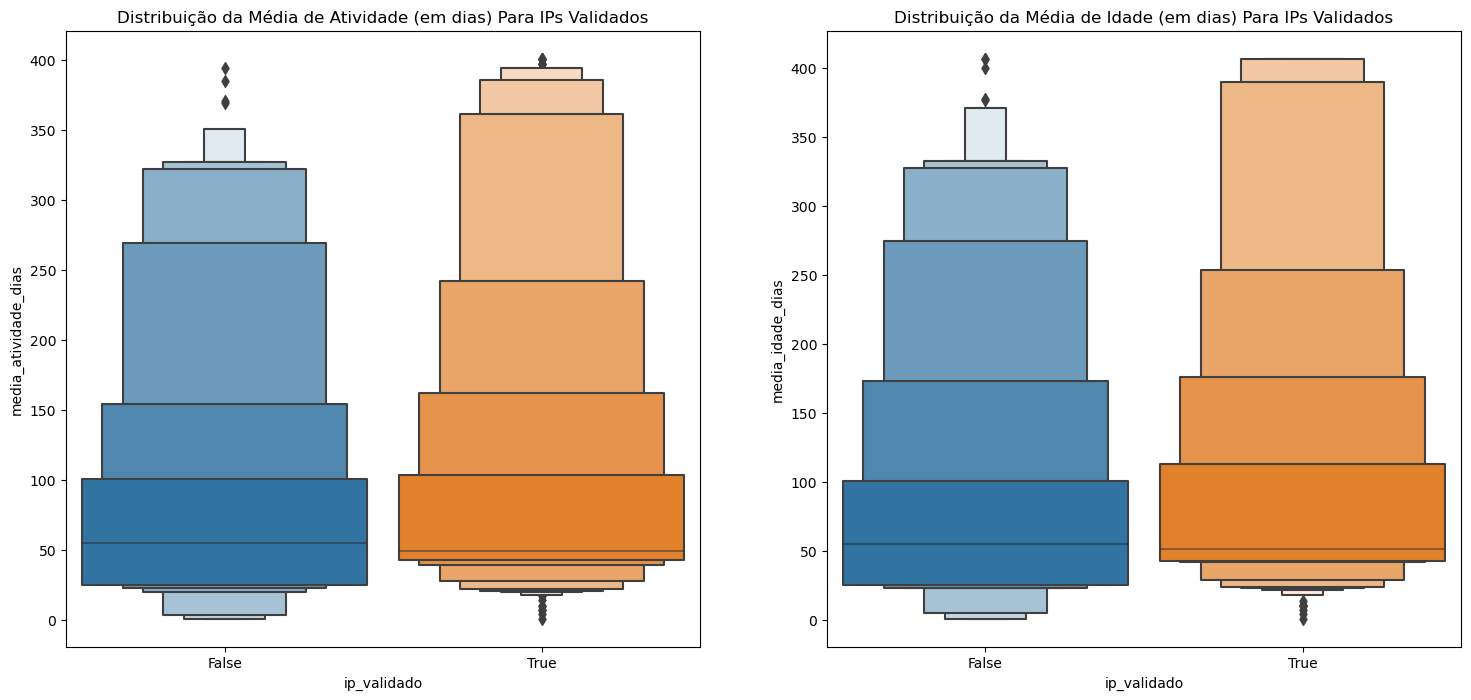

In [ ]:
# Plot

# Subplots
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,8))

# Plot 1
sns.boxenplot(data = df, x = "ip_validado", y = "media_atividade_dias", scale = "linear", width = 0.9, ax = ax[0])
ax[0].set_title("Distribuição da Média de Atividade (em dias) Para IPs Validados", fontsize = 12)

# Plot 2
sns.boxenplot(data = df, x = "ip_validado", y = "media_idade_dias", scale = "linear", width = 0.9, ax = ax[1])
ax[1].set_title("Distribuição da Média de Idade (em dias) Para IPs Validados", fontsize = 12)

fig.show()

Análise:

* IPs maliciosos validados têm médias maiores.

In [ ]:
df_valid.head()

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,43
3,78,[20],0,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,1
7,114,"[63782, 77576, 54740, 72791, 22111]",0,True,4134.0,39891.0,Chinanet,20.856758,0,5
10,190,"[75299, 87575, 78501, 5738, 75596, 13358, 7371...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,11
13,408,"[98400, 29891, 51209, 95562, 69227, 11444, 31541]",4,True,63949.0,2939.0,"Linode, LLC",13.156681,2,7


In [ ]:
# Vamos incluir os resultados anteriores no df de ips validados
df_valid["media_atividade_dias"] = df_valid.id_agente.apply(lambda x: dados2.set_index("id_agente").loc[x].atividade_dias.mean())
df_valid["media_idade_dias"] = df_valid.id_agente.apply(lambda x: dados2.set_index("id_agente").loc[x].atividade_dias.mean())

In [ ]:
# Os 10 Agentes Que Registraram o Maior Número de Ataques
top10_agentes = dados2.sort_values(by = 'num_ips_reportados', ascending = False)['id_agente'][:10].values
print("Os 10 Agentes Que Registraram o Maior Número de Ataques:\n")
for id in top10_agentes :
    print(dados2[dados2["id_agente"]==id].id_agente.item())

Os 10 Agentes Que Registraram o Maior Número de Ataques:

47
92263
9662
9663
9563
7286
77642
24249
715
561


In [ ]:
df.head(3)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias
0,3,[21],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1,397.000000,407.000000
1,4,[25],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1,401.000000,407.000000
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,43,141.883721,163.116279


In [ ]:
df_valid.head(3)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,43,141.883721,141.883721
3,78,[20],0,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,1,385.000000,385.000000
7,114,"[63782, 77576, 54740, 72791, 22111]",0,True,4134.0,39891.0,Chinanet,20.856758,0,5,87.000000,87.000000


In [ ]:
# Proporção entre atividade e idade
df['prop_agentes'] = df['media_atividade_dias'] / df['media_idade_dias']

In [ ]:
# Proporção entre atividade e idade nos ips validados
df_valid['prop_agentes'] = df_valid['media_atividade_dias'] / df_valid['media_idade_dias']

In [ ]:
df.head(3)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias,prop_agentes
0,3,[21],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1,397.000000,407.000000,0.975430
1,4,[25],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,1,401.000000,407.000000,0.985258
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,43,141.883721,163.116279,0.869832


In [ ]:
df_valid.head(3)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias,prop_agentes
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,43,141.883721,141.883721,1.0
3,78,[20],0,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,1,385.000000,385.000000,1.0
7,114,"[63782, 77576, 54740, 72791, 22111]",0,True,4134.0,39891.0,Chinanet,20.856758,0,5,87.000000,87.000000,1.0


### Padronização dos Dados (Coloca tudo na mesma escala)

In [ ]:
# Padronizador
minmaxscaler = MinMaxScaler(feature_range = (0, 1))

In [ ]:
# Padroniza os dados no df

_ = df['media_atividade_dias'].values.reshape(-1, 1)
df['media_atividade_dias'] = minmaxscaler.fit_transform(_)

_ = df['media_idade_dias'].values.reshape(-1, 1)
df['media_idade_dias'] = minmaxscaler.fit_transform(_)

_ = df['num_id_agente'].values.reshape(-1, 1)
df['num_id_agente'] = minmaxscaler.fit_transform(_)

In [ ]:
# Padroniza os dados no df_valid

_ = df_valid['media_atividade_dias'].values.reshape(-1, 1)
df_valid['media_atividade_dias'] = minmaxscaler.fit_transform(_)

_ = df_valid['media_idade_dias'].values.reshape(-1, 1)
df_valid['media_idade_dias'] = minmaxscaler.fit_transform(_)

_ = df_valid['num_id_agente'].values.reshape(-1, 1)
df_valid['num_id_agente'] = minmaxscaler.fit_transform(_)

In [ ]:
df.head(3)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias,prop_agentes
0,3,[21],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,0.000,0.990000,1.000000,0.975430
1,4,[25],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,0.000,1.000000,1.000000,0.985258
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,0.168,0.352209,0.399301,0.869832


In [ ]:
df_valid.head(3)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias,prop_agentes
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,0.237288,0.352209,0.352209,1.0
3,78,[20],0,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,0.000000,0.960000,0.960000,1.0
7,114,"[63782, 77576, 54740, 72791, 22111]",0,True,4134.0,39891.0,Chinanet,20.856758,0,0.022599,0.215000,0.215000,1.0


## Análise de Grafos

Grafo $G = (V,E)$ onde um nó $v$ é um IP malicioso e uma aresta $e$ liga dois IPs maliciosos se eles forem reportados pelo mesmo agente. Portanto, as bordas são ponderadas pelo número de vezes que 2 IPs maliciosos foram reportados pelos mesmos agente.

Cada IP malicioso estará associado a um tipo de ataque.

In [ ]:
# Vamos considerar somente alguns atributos (caso contrário pode ficar inviável criar o grafo)
atributos = df_valid.set_index("id_registro_ip")[["prop_agentes",
                                                  "num_ips_reportados_bc",
                                                  "ips_reportados_binned",
                                                  "num_id_agente",
                                                  "media_atividade_dias",
                                                  "media_idade_dias"]].to_dict(orient = "index")

In [ ]:
# Define as classes
classes = df_valid.set_index("id_registro_ip")[["tipo_ataque"]].to_dict(orient = "index")

In [ ]:
# Dicionário para inicializar os nodes (cada node é a combinação das variáveis de entrada para cada IP malicioso)
for key, value in atributos.items():
    atributos[key] = list(value.values())

In [ ]:
atributos

{9: [1.0,
  3.088124185690707,
  1,
  0.23728813559322035,
  0.3522093023255814,
  0.3522093023255814],
 78: [1.0, 10.018187803796714, 2, 0.0, 0.9600000000000001, 0.9600000000000001],
 114: [1.0, 20.85675773950267, 0, 0.022598870056497175, 0.215, 0.215],
 190: [1.0,
  3.088124185690707,
  1,
  0.05649717514124293,
  0.18613636363636363,
  0.18613636363636363],
 408: [1.0,
  13.156681062379239,
  2,
  0.033898305084745756,
  0.22535714285714284,
  0.22535714285714284],
 508: [1.0, 10.269354173586333, 2, 0.0, 1.0, 1.0],
 617: [1.0, 6.856340371994583, 1, 0.0, 0.8500000000000001, 0.8500000000000001],
 980: [1.0, 4.485897582581857, 1, 0.0, 0.105, 0.105],
 1146: [1.0,
  10.467078370641149,
  2,
  0.0,
  0.9750000000000001,
  0.9750000000000001],
 1219: [1.0,
  13.698492338788492,
  2,
  0.0,
  0.5525000000000001,
  0.5525000000000001],
 1230: [1.0, 20.85675773950267, 0, 0.005649717514124294, 0.21125, 0.21125],
 1372: [1.0, 10.269354173586333, 2, 0.01694915254237288, 0.446875, 0.446875],
 143

In [ ]:
# Dicionário para inicializar as classes (variável alvo = tipo de ataque)
for key, value in classes.items():
    classes[key] = list(value.values())

In [ ]:
classes

{9: [0],
 78: [0],
 114: [0],
 190: [0],
 408: [4],
 508: [2],
 617: [5],
 980: [4],
 1146: [0],
 1219: [5],
 1230: [0],
 1372: [5],
 1437: [3],
 1883: [0],
 2374: [0],
 2449: [0],
 2533: [4],
 2536: [0],
 2567: [4],
 2853: [4],
 2859: [4],
 2903: [4],
 2913: [4],
 3064: [4],
 3169: [4],
 3177: [4],
 3218: [4],
 3257: [4],
 3364: [4],
 3472: [3],
 3482: [4],
 3758: [4],
 3777: [4],
 3936: [4],
 3949: [4],
 3999: [4],
 4185: [4],
 4283: [4],
 4771: [4],
 4855: [4],
 4870: [4],
 4882: [4],
 4923: [4],
 4995: [0],
 5209: [0],
 5238: [4],
 5288: [0],
 5429: [4],
 5674: [0],
 6009: [4],
 6130: [5],
 6209: [4],
 6241: [4],
 6406: [4],
 6512: [4],
 6529: [4],
 6557: [4],
 6666: [4],
 6701: [0],
 6713: [4],
 6726: [4],
 6884: [4],
 6895: [4],
 6908: [4],
 6929: [5],
 7093: [5],
 7100: [4],
 7138: [0],
 7308: [4],
 7478: [0],
 7513: [4],
 7688: [4],
 7708: [4],
 7792: [4],
 7863: [4],
 7996: [4],
 8063: [4],
 8432: [3],
 8613: [4],
 8681: [4],
 8757: [5],
 8884: [5],
 9250: [4],
 9295: [0],
 92

In [ ]:
# Define os nodes do grafo
nodes_id = df_valid.id_registro_ip.to_list()

In [ ]:
# Cria os nodes associando atributos e classes
nodes = [(node, {'x':atributos[node], 'y':classes[node]}) for node in nodes_id]

In [ ]:
nodes

[(9,
  {'x': [1.0,
    3.088124185690707,
    1,
    0.23728813559322035,
    0.3522093023255814,
    0.3522093023255814],
   'y': [0]}),
 (78,
  {'x': [1.0,
    10.018187803796714,
    2,
    0.0,
    0.9600000000000001,
    0.9600000000000001],
   'y': [0]}),
 (114,
  {'x': [1.0, 20.85675773950267, 0, 0.022598870056497175, 0.215, 0.215],
   'y': [0]}),
 (190,
  {'x': [1.0,
    3.088124185690707,
    1,
    0.05649717514124293,
    0.18613636363636363,
    0.18613636363636363],
   'y': [0]}),
 (408,
  {'x': [1.0,
    13.156681062379239,
    2,
    0.033898305084745756,
    0.22535714285714284,
    0.22535714285714284],
   'y': [4]}),
 (508, {'x': [1.0, 10.269354173586333, 2, 0.0, 1.0, 1.0], 'y': [2]}),
 (617,
  {'x': [1.0,
    6.856340371994583,
    1,
    0.0,
    0.8500000000000001,
    0.8500000000000001],
   'y': [5]}),
 (980, {'x': [1.0, 4.485897582581857, 1, 0.0, 0.105, 0.105], 'y': [4]}),
 (1146,
  {'x': [1.0,
    10.467078370641149,
    2,
    0.0,
    0.9750000000000001,
    

In [ ]:
# Define as arestas ponderadas não direcionadas.
# As bordas (arestas) são ponderadas pelo número de vezes que 2 IPs maliciosos foram reportados pelos mesmos agentes.
lista_agentes = df_valid.id_agente.to_list()
edges = []
for i in range(len(nodes_id)):
    for j in range(i + 1, len(nodes_id)):
        weight = len(set(lista_agentes[i])&set(lista_agentes[j]))
        if weight!=0 :
            edges.append((nodes_id[i], nodes_id[j], weight))

In [ ]:
# Cria o grafo
graph = nx.Graph()

In [ ]:
graph

In [ ]:
# Adiciona os nodes ao grafo
graph.add_nodes_from(nodes)

In [ ]:
# Adiciona as arestas ao grafo
graph.add_weighted_edges_from(edges)

In [ ]:
# Número de nodes
nb_nodes = graph.number_of_nodes()
nb_nodes

3187

In [ ]:
# Número de arestas
nb_edges = graph.number_of_edges()
nb_edges

489474

### Criação do Sub-Grafo

Se tentarmos criar o plot do grafo agora pode travar o computador, pois o volume de arestas é muito grande. Vamos então filtrar (somente para criar a visualização do grafo).

Criaremos um sub-grafo somente com 20 nodes dos agentes que mais reportaram IPs maliciosos. Faremos isso para facilitar a visualização.

In [ ]:
# Filtra os 20 agentes que aparecem mais vezes
n = 20
df_20 = df_valid.loc[df_valid.num_id_agente.nlargest(n).index]

In [ ]:
df_20.head(3)

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias,prop_agentes
5754,700748,"[3589, 51209, 46094, 1045, 38933, 21015, 69656...",0,True,56046.0,1449.0,China Mobile communications corporation,11.440444,2,1.000000,0.300787,0.300787,1.0
5497,674918,"[51209, 46094, 1045, 38933, 21015, 69656, 2972...",0,True,4134.0,39891.0,Chinanet,20.856758,0,0.988701,0.298097,0.298097,1.0
6638,850077,"[51209, 46094, 1045, 21015, 29726, 90149, 3946...",0,True,4134.0,39891.0,Chinanet,20.856758,0,0.988701,0.305043,0.305043,1.0


In [ ]:
# Lista de nodes
nodes_20 = df_20.id_registro_ip.tolist()

In [ ]:
# Associa nodes e arestas
lista_agentes_20 = df_20.id_agente.tolist()
edges_20 = []
for i in range(len(nodes_20)):
    for j in range(i+1,len(nodes_20)):
        weight = len(set(lista_agentes_20[i])&set(lista_agentes_20[j]))
        if weight!=0 :
            edges_20.append((nodes_20[i], nodes_20[j], weight))

Leia o manual em pdf no Capítulo 5 com os detalhes sobre o que é matriz adjacente.

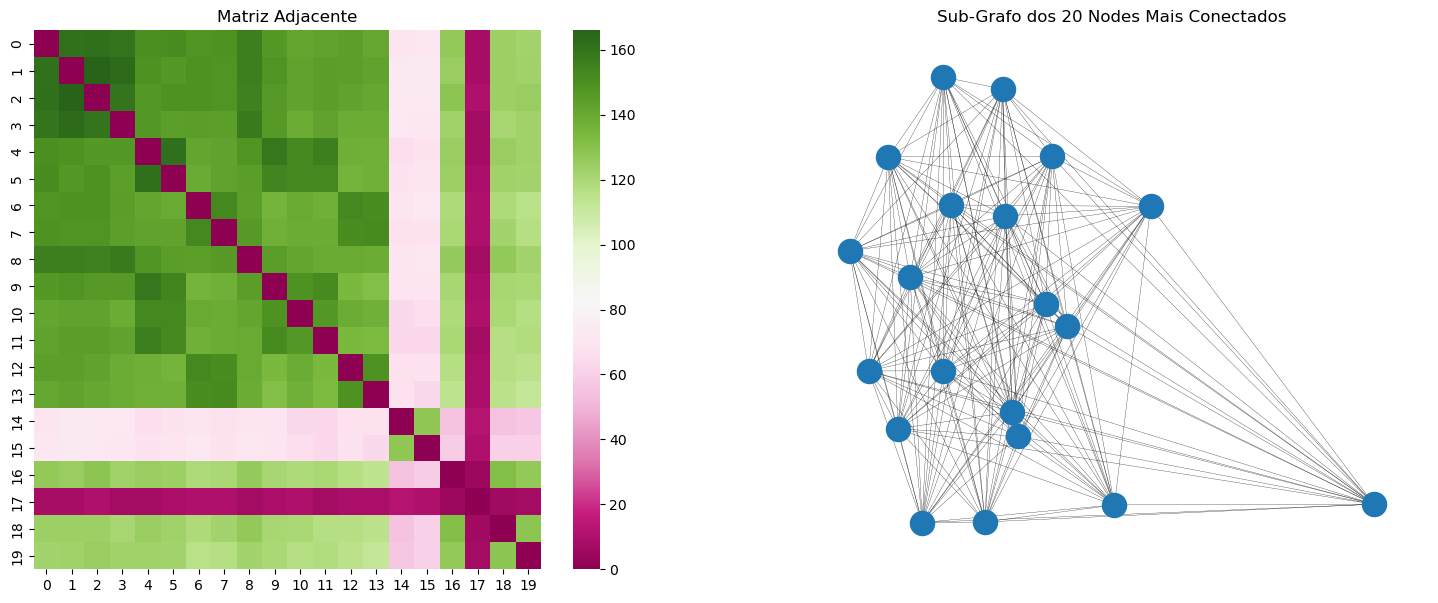

In [ ]:
# Cria o grafo
graph_20 = nx.Graph()

# Adiciona os nodes
graph_20.add_nodes_from(nodes_20)

# Adiciona as arestas
graph_20.add_weighted_edges_from(edges_20)

# Número de nodes e arestas
nb_nodes = graph_20.number_of_nodes()
nb_edges = graph_20.number_of_edges()

# Matriz adjacente
adj_20 = nx.adjacency_matrix(graph_20)

# Subplot
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,7))

# Heatmap
sns.heatmap(adj_20.todense(), cmap = "PiYG", ax = ax[0])
ax[0].set_title("Matriz Adjacente", fontsize = 12)


nx.draw(graph_20, pos = nx.spring_layout(graph_20, seed = 8), width = 0.2)
ax[1].set_title("Sub-Grafo dos 20 Nodes Mais Conectados", fontsize = 12)

fig.show()

## Modelagem com Graph Convolutional Network

Para o treinamento usaremos o grafo original criando anteriormente.

In [ ]:
# Extrai do grafo os dados correspondentes
dados_grafo = from_networkx(graph)

In [ ]:
dados_grafo

Data(x=[3187, 6], edge_index=[2, 978948], y=[3187, 1], weight=[978948])

In [ ]:
# Taxa de divisão treino/teste (deixaremos 10% para teste)
train_ratio = 0.8
val_ratio = 0.1

In [ ]:
# Obtém o shape
n_nodes = dados_grafo.x.shape[0]
n_nodes

3187

In [ ]:
# Cria a taxa de treino
num_treino = int(n_nodes * train_ratio)
num_treino

2549

In [ ]:
# Cria a taxa de validação
num_val = int(n_nodes * val_ratio)
num_val

318

In [ ]:
# Extrai o índice
index = [i for i in range(n_nodes)]

In [ ]:
# Shuffle do índice
np.random.shuffle(index)

In [ ]:
# Dados de treino
train_mask = torch.full_like(dados_grafo.y, False, dtype = bool)
train_mask[index[:num_treino]] = True

In [ ]:
# Dados de teste
test_mask = torch.full_like(dados_grafo.y, False, dtype = bool)
test_mask[index[num_treino:num_treino + num_val]] = True

In [ ]:
# Dados de validação
val_mask = torch.full_like(dados_grafo.y, False, dtype = bool)
val_mask[index[num_treino + num_val:]] = True

In [ ]:
# Dados finais
dados_grafo.train_mask = train_mask
dados_grafo.test_mask = test_mask
dados_grafo.val_mask = val_mask

### Criando o Modelo GCN

Leia o manual em pdf no Capítulo 5 sobre a Arquitetura Graph Convolutional Networks (GCNs).

![DSA](imagens/gcn_web.png)

In [ ]:
# Classe do modelo
class ModeloGCN(torch.nn.Module):

    # Método construtor
    def __init__(self, number_of_features, number_of_classes):

        super().__init__()

        torch.manual_seed(888)

        # Camadas
        self.conv1 = GCNConv(number_of_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.classifier = nn.Linear(64, number_of_classes)

    # Método forward
    def forward(self, x, edge_index):

        # Passada para frente
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()

        # Previsão
        out = self.classifier(h)

        return out, h

In [ ]:
# Cria o modelo
gcn = ModeloGCN(6, 6)

In [ ]:
# Otimizador
optimizer = Adam(gcn.parameters(), lr=0.06)

In [ ]:
# Função de perda
criterion = nn.CrossEntropyLoss()

In [ ]:
# Passadas de treinamento
epochs = 400

In [ ]:
# Grava o modelo em disco
writer = SummaryWriter(log_dir = "output/gcn/")

### Treinamento

In [ ]:
%%time

# Barra de progressão
loop = tqdm(range(1, epochs + 1))

# Loop de treinamento
for epoch in loop:

    # Coloca o modelo em modo de treino
    gcn.train()

    # Limpa os gradientes
    optimizer.zero_grad()

    # Faz a previsão com o modelo
    out,_ = gcn(dados_grafo.x, dados_grafo.edge_index)

    # Calcula o erro do modelo
    loss = criterion(out[dados_grafo.train_mask.flatten()], dados_grafo.y[dados_grafo.train_mask].flatten())

    # Backpropagation
    loss.backward()

    # Otimização dos pesos
    optimizer.step()

    # Seleciona a classe com mais alta probabilidade
    pred = out.argmax(dim = 1)

    # Validação
    val_correct = pred[dados_grafo.val_mask.flatten()] == dados_grafo.y[dados_grafo.val_mask]

    # Taxa de acertos
    val_acc = int(val_correct.sum()) / int(dados_grafo.val_mask.sum())

    # Log
    loop.set_postfix_str(f'\nErro em Treino: {loss:.4f} Acurácia em Validação : {val_acc:.4f}')
    writer.add_scalars("losses", {"train": np.round(loss.item(),3)}, epoch)

  0%|                                                      | 0/400 [00:00<?, ?it/s,                                | 0/400 [00:00<?, ?it/s]
  0%|                                              | 1/400 [00:00<02:01,  3.29it/s, 
  0%|                                              | 1/400 [00:00<02:01,  3.29it/s, 
  0%|▏                                             | 2/400 [00:00<01:49,  3.64it/s, 
  0%|▏                                             | 2/400 [00:00<01:49,  3.64it/s, 
  1%|▎                                             | 3/400 [00:00<01:46,  3.74it/s, 
  1%|▎                                             | 3/400 [00:01<01:46,  3.74it/s, 
  1%|▍                                             | 4/400 [00:01<01:43,  3.84it/s, 
  1%|▍                                             | 4/400 [00:01<01:43,  3.84it/s, 
  1%|▌                                             | 5/400 [00:01<01:42,  3.84it/s, 
  1%|▌                                             | 5/400 [00:01<01:42,  3.84it/s, 
  2%|▋    

 12%|█████▍                                       | 48/400 [00:12<01:32,  3.79it/s, 
 12%|█████▌                                       | 49/400 [00:12<01:32,  3.81it/s, 
 12%|█████▌                                       | 49/400 [00:13<01:32,  3.81it/s, 
 12%|█████▋                                       | 50/400 [00:13<01:31,  3.84it/s, 
 12%|█████▋                                       | 50/400 [00:13<01:31,  3.84it/s, 
 13%|█████▋                                       | 51/400 [00:13<01:30,  3.85it/s, 
 13%|█████▋                                       | 51/400 [00:13<01:30,  3.85it/s, 
 13%|█████▊                                       | 52/400 [00:13<01:30,  3.83it/s, 
 13%|█████▊                                       | 52/400 [00:13<01:30,  3.83it/s, 
 13%|█████▉                                       | 53/400 [00:13<01:31,  3.81it/s, 
 13%|█████▉                                       | 53/400 [00:14<01:31,  3.81it/s, 
 14%|██████                                       | 54/400 [00:14

 36%|███████████████▊                            | 144/400 [00:38<01:06,  3.86it/s, 
 36%|███████████████▉                            | 145/400 [00:38<01:05,  3.87it/s, 
 36%|███████████████▉                            | 145/400 [00:38<01:05,  3.87it/s, 
 36%|████████████████                            | 146/400 [00:38<01:05,  3.85it/s, 
 36%|████████████████                            | 146/400 [00:38<01:05,  3.85it/s, 
 37%|████████████████▏                           | 147/400 [00:38<01:05,  3.86it/s, 
 37%|████████████████▏                           | 147/400 [00:38<01:05,  3.86it/s, 
 37%|████████████████▎                           | 148/400 [00:38<01:04,  3.89it/s, 
 37%|████████████████▎                           | 148/400 [00:39<01:04,  3.89it/s, 
 37%|████████████████▍                           | 149/400 [00:39<01:04,  3.89it/s, 
 37%|████████████████▍                           | 149/400 [00:39<01:04,  3.89it/s, 
 38%|████████████████▌                           | 150/400 [00:39

 60%|██████████████████████████▍                 | 240/400 [01:03<00:41,  3.83it/s, 
 60%|██████████████████████████▌                 | 241/400 [01:03<00:41,  3.80it/s, 
 60%|██████████████████████████▌                 | 241/400 [01:03<00:41,  3.80it/s, 
 60%|██████████████████████████▌                 | 242/400 [01:03<00:41,  3.79it/s, 
 60%|██████████████████████████▌                 | 242/400 [01:03<00:41,  3.79it/s, 
 61%|██████████████████████████▋                 | 243/400 [01:03<00:41,  3.81it/s, 
 61%|██████████████████████████▋                 | 243/400 [01:04<00:41,  3.81it/s, 
 61%|██████████████████████████▊                 | 244/400 [01:04<00:40,  3.84it/s, 
 61%|██████████████████████████▊                 | 244/400 [01:04<00:40,  3.84it/s, 
 61%|██████████████████████████▉                 | 245/400 [01:04<00:40,  3.84it/s, 
 61%|██████████████████████████▉                 | 245/400 [01:04<00:40,  3.84it/s, 
 62%|███████████████████████████                 | 246/400 [01:04

 84%|████████████████████████████████████▉       | 336/400 [01:28<00:16,  3.82it/s, 
 84%|█████████████████████████████████████       | 337/400 [01:28<00:16,  3.84it/s, 
 84%|█████████████████████████████████████       | 337/400 [01:28<00:16,  3.84it/s, 
 84%|█████████████████████████████████████▏      | 338/400 [01:28<00:16,  3.80it/s, 
 84%|█████████████████████████████████████▏      | 338/400 [01:29<00:16,  3.80it/s, 
 85%|█████████████████████████████████████▎      | 339/400 [01:29<00:16,  3.75it/s, 
 85%|█████████████████████████████████████▎      | 339/400 [01:29<00:16,  3.75it/s, 
 85%|█████████████████████████████████████▍      | 340/400 [01:29<00:16,  3.72it/s, 
 85%|█████████████████████████████████████▍      | 340/400 [01:29<00:16,  3.72it/s, 
 85%|█████████████████████████████████████▌      | 341/400 [01:29<00:16,  3.69it/s, 
 85%|█████████████████████████████████████▌      | 341/400 [01:29<00:16,  3.69it/s, 
 86%|█████████████████████████████████████▌      | 342/400 [01:29

CPU times: user 7min 36s, sys: 2min 41s, total: 10min 17s
Wall time: 1min 45s


### Avaliação

In [ ]:
# Coloca o modelo em modo de avaliação
gcn.eval()

# Extrai as previsões do modelo
out,_ = gcn(dados_grafo.x, dados_grafo.edge_index)

# Seleciona a classe com mais alta probabilidade
pred = out.argmax(dim = 1)

# Seleciona as previsões corretas com base nos dados de teste
test_correct = pred[dados_grafo.test_mask.flatten()] == dados_grafo.y[dados_grafo.test_mask]

# Calcula a acurácia
test_acc = int(test_correct.sum()) / int(dados_grafo.test_mask.sum())

print(f'Acurácia em Teste: {test_acc:.2f}')

Acurácia em Teste: 0.85


In [ ]:
pred[dados_grafo.test_mask.flatten()]

tensor([0, 0, 4, 4, 4, 0, 0, 0, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 0, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 0, 4, 3, 0, 0, 4, 4,
        4, 4, 0, 4, 0, 4, 0, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4,
        4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 4,
        0, 4, 4, 4, 0, 4, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 0, 4, 3, 4,
        4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 4, 0, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 3, 4,
        4, 4, 4, 4, 4, 3, 4, 1, 4, 1, 1, 1, 1, 1, 0, 1, 1, 1, 4, 4, 1, 4, 1, 1,
        1, 1, 1, 1, 1, 0, 4, 1, 4, 1, 4,

As previsões em **pred** são uma lista de número que representam as classes previstas para cada nó do grafo de entrada. Cada inteiro na lista corresponde à classe prevista para o nó na posição correspondente do conjunto de dados de teste.

Por exemplo, se pred for igual a [1, 2, 0, 1, 2, ...], isso significa que o modelo previu que o primeiro nó no conjunto de dados de teste pertence à classe 1, o segundo nó pertence à classe 2, o terceiro nó pertence à classe 0 e assim por diante.

Para interpretar e explicar as previsões, é importante ter em mente que a saída da rede GCN para a classificação de grafos é uma matriz de probabilidades de classe para cada nó. No exemplo, a função F.log_softmax é usada para normalizar as saídas em uma distribuição de probabilidade, permitindo que sejam interpretadas como a probabilidade de um nó pertencer a cada classe.

Portanto, é possível interpretar as previsões de pred como a classe com a maior probabilidade para cada nó do grafo de entrada, ou seja, a classe que o modelo acredita ser a mais provável para cada nó.

No exemplo, as previsões podem ser interpretadas como: o modelo prevê que o primeiro nó no conjunto de dados de teste pertence à classe 1 com a maior probabilidade, o segundo nó pertence à classe 2 com a maior probabilidade, o terceiro nó pertence à classe 0 com a maior probabilidade, e assim por diante.

Essas previsões podem ser usadas para identificar padrões e entender o comportamento dos dados. Por exemplo, se houver um grande número de nós previstos como pertencentes a uma determinada classe, isso pode indicar que os nós compartilham algumas características em comum e que essa classe pode ser importante para entender o problema que está sendo resolvido.






In [ ]:
G = nx.Graph()

In [ ]:
G.add_nodes_from(range(dados_grafo.num_nodes))

In [ ]:
G.add_edges_from(dados_grafo.edge_index.t().tolist())

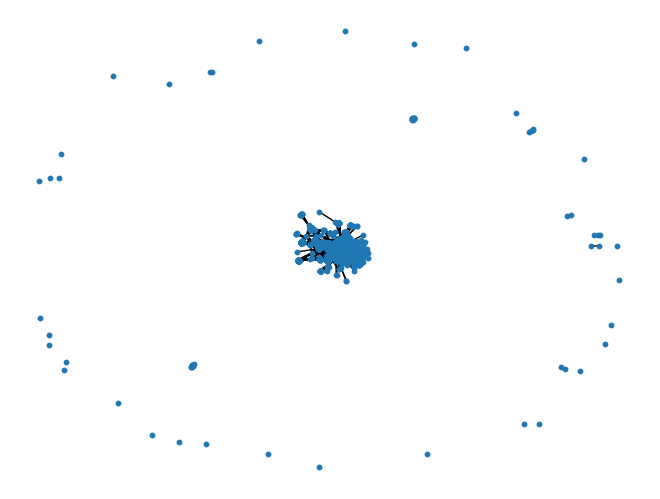

In [ ]:
# Desenhar o grafo com as classes previstas
nx.draw(G, node_size = 10, with_labels = False)
plt.show()

In [ ]:
# Cria a rede
net = Network()

In [ ]:
# Inclui botões
net.show_buttons(filter_=['physics'])

In [ ]:
# Adiciona os nodes à rede
for node in G.nodes:
    net.add_node(node, label = node)

Adiciona as arestas à rede.

In [ ]:
%%time
for edge in G.edges:
    net.add_edge(edge[0], edge[1])

CPU times: user 1h 42min 22s, sys: 1min 44s, total: 1h 44min 7s
Wall time: 1h 44min 8s


In [ ]:
net.show("output/projeto4.html")

## Aprendizado Semi-Supervisionado Para Preenchimento de Label

No aprendizado semi-supervisionado, as GNNs são uma das formas avançadas e mais robustas de fazê-lo. Porque a matriz de adjacência A nos dá a possibilidade de decompô-la em uma matriz de Laplacien que nos ajuda em muitos algoritmos, como agrupamento espectral (um poderoso método de agrupamento), entre outros algoritmos.

**Adjacency matrix**
\begin{align*}
A_{ij} = \left\{
    \begin{array}{ll}
    1 &\text{ if } e_{ij}\in E\\
    0 &\text{ if } e_{ij}\notin E
    \end{array}
    \right.
\end{align*}

**Degree matrix**
\begin{align*}
D_{ij} = \left\{
    \begin{array}{ll}
    \mbox{deg}(v_i) &\text{ if } i=j\\
    0 &\text{ if } i\neq j
    \end{array}
    \right.
\end{align*}

**Laplacian**
\begin{align*}
L &= D - A.
\end{align*}

**Normalized Laplacian**
\begin{align*}
L &= I - D^{-1/2} A D^{-1/2}
\end{align*}

In [ ]:
df.head()

,id_registro_ip,id_agente,tipo_ataque,ip_validado,id_provedor,num_ips_reportados,nome_provedor,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias,prop_agentes
0,3,[21],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,0.000,0.990000,1.000000,0.975430
1,4,[25],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,0.000,1.000000,1.000000,0.985258
2,9,"[20354, 3587, 83714, 34181, 33423, 52497, 786,...",0,True,206728.0,14.0,Media Land LLC,3.088124,1,0.168,0.352209,0.399301,0.869832
3,78,[20],0,True,9299.0,769.0,Philippine Long Distance Telephone Company,10.018188,2,0.000,0.960000,1.000000,0.945946
4,92,[28],2,NaN,16509.0,30914.0,AMAZON-02,19.997131,0,0.000,0.982500,1.000000,0.968059


In [ ]:
df = df.reset_index()

In [ ]:
df = df.set_index('id_registro_ip')

In [ ]:
dados = df[["prop_agentes",
            "tipo_ataque",
            "num_ips_reportados_bc",
            "ips_reportados_binned",
            "num_id_agente",
            "media_atividade_dias",
            "media_idade_dias"]]

In [ ]:
# One-Hot Encoding
tipo_ataque_encoded = pd.get_dummies(dados['tipo_ataque'])
dados = dados.drop('tipo_ataque', axis = 1)
dados = pd.concat([dados, tipo_ataque_encoded], axis=1)

In [ ]:
# Mapeando todo o dataframe, colocando -1 nos dados não rotulados
labels = df['ip_validado'].replace({True:1,False:0,np.nan:-1})

In [ ]:
dados.head(3)

,prop_agentes,num_ips_reportados_bc,ips_reportados_binned,num_id_agente,media_atividade_dias,media_idade_dias,0,1,2,3,4,5
id_registro_ip,,,,,,,,,,,,
3,0.975430,19.997131,0,0.000,0.990000,1.000000,0,0,1,0,0,0
4,0.985258,19.997131,0,0.000,1.000000,1.000000,0,0,1,0,0,0
9,0.869832,3.088124,1,0.168,0.352209,0.399301,1,0,0,0,0,0


In [ ]:
# Exportando os dados
dados.to_csv('output/dados_finais.csv')
labels.to_csv('output/labels.csv')

In [ ]:
# Importando os dados
X = pd.read_csv('output/dados_finais.csv')
X = X.to_numpy()
y = pd.read_csv('output/labels.csv')
y = y['ip_validado']

### Label Propagation

O objetivo aqui é minimizar uma função de perda que possui propriedades de regularização e geralmente é mais robusta ao ruído. O algoritmo itera em uma versão modificada do grafo original e normaliza os pesos das arestas calculando a matriz Laplaciana do grafo normalizado. Este procedimento também é usado no agrupamento espectral.

In [ ]:
# Fit de todo o dataset
label_prop_model = LabelPropagation()
label_prop_model.fit(X, y)

LabelPropagation()

In [ ]:
# Previsão com todo o dataset
pred_lb = label_prop_model.predict(X)
print("Precisão da Distribuição de Rótulos: ",'{:.2%}'.format(label_prop_model.score(X, pred_lb)))

Precisão da Distribuição de Rótulos:  100.00%


In [ ]:
# Usando esses rótulos recém-previstos para construir um modelo XGBoost (modelo baseado em árvore),
# sem ajuste de hiperparâmetros (modelo simples)
xgb = xgboost.XGBClassifier()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, pred_lb, test_size = 0.1, random_state = 888)

In [ ]:
# Treino do modelo
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Pontuações na validação cruzada de 4 folds
scores = cross_val_score(xgb, X_train, y_train, scoring = "accuracy", cv = 4)
scores

array([0.94678256, 0.9484599 , 0.94861238, 0.94890956])

In [ ]:
# Relatório de classificação
y_pred = xgb.predict(X_test)
cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2510
         1.0       0.90      0.78      0.84       405

    accuracy                           0.96      2915
   macro avg       0.93      0.88      0.91      2915
weighted avg       0.96      0.96      0.96      2915



# Fim